In [ ]:
#Environment Setup

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#Preprocess the Images
def preprocess_image(image_path):
    # Load image and apply transformations
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((512, 512)),   # Resize for faster processing
        T.ToTensor(),
    ])
    return transform(image).unsqueeze(0)


In [ ]:
#Initialize the Region Proposal Network (RPN) using Faster R-CNN
# Load a pre-trained Faster R-CNN model with ResNet-50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#Extract Regions Using the RPN
def extract_regions(model, image):
    with torch.no_grad():
        predictions = model(image)

    return predictions[0]["boxes"], predictions[0]["scores"]


In [ ]:
#Filter Regions and Apply Transfer Learning with CNN
# Load and modify a pre-trained ResNet model for fracture detection
cnn_model = resnet18(pretrained=True)
cnn_model.fc = torch.nn.Linear(cnn_model.fc.in_features, 2)  # Binary classification: Fracture or No Fracture
cnn_model.eval()

def classify_regions(image, boxes, cnn_model, threshold=0.5):
    # Prepare regions and predict fracture probability
    fracture_regions = []
    for box in boxes:
        cropped_img = image[:, :, int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        output = cnn_model(cropped_img)
        prob = torch.nn.functional.softmax(output, dim=1)[0, 1].item()  # Probability of fracture
        if prob > threshold:
            fracture_regions.append((box, prob))
    return fracture_regions


In [ ]:
#Visualize Fracture Regions with Bounding Boxes and Heatmaps
def plot_detections(image, fracture_regions):
    image_np = image.squeeze().permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    for box, prob in fracture_regions:
        plt.gca().add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                          fill=False, edgecolor="red", linewidth=2)
        )
        plt.text(box[0], box[1], f"{prob:.2f}", color="yellow", fontsize=12)
    plt.show()


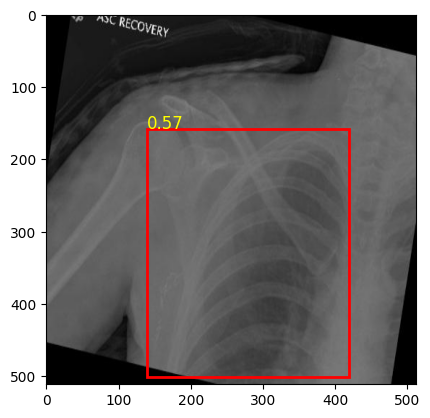

In [ ]:
#Run the Full Pipeline
image_path = "fractured_image_1.jpg"
image = preprocess_image(image_path)

# Step 1: Extract regions
boxes, scores = extract_regions(model, image)

# Step 2: Classify regions
fracture_regions = classify_regions(image, boxes, cnn_model)

# Step 3: Visualize detected fractures
plot_detections(image, fracture_regions)
